## Fraud

### Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards or doing money laundry. 

Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning. 

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

### Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user first transaction on the site and based on that you have to make your classification (“fraud/no fraud”).

These are the tasks you are asked to do:
- [For each user, determine their country based on the IP address](#1)

- [Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model](#2)

- [Your boss is a bit worried about using a model she doesn’t understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn’t care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?](#3)

- [Let’s say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?](#4) 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('precision',2)

In [2]:
df1 = pd.read_csv("Fraud_Data.csv")

In [3]:
df1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.33e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.50e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.84e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.16e+08,0


In [4]:
#convert two time columns into datetime objects
df1[['signup_time','purchase_time']] = df1[['signup_time','purchase_time']].apply(pd.to_datetime)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


#### Dataset#1 Description
user_id : Id of the user. Unique by user

signup_time : the time when the user created her account (GMT time)

purchase_time : the time when the user bought the item (GMT time)

purchase_value : the cost of the item purchased (USD)

device_id : the device id. You can assume that it is unique by device. I.e., same device ID means that the same physical device was used for the transaction

source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser)

browser : the browser used by the user

sex : user sex: Male/Female

age : user age

ip_address : user numeric ip address

class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0) 

In [5]:
df2 = pd.read_csv("IpAddress_to_Country.csv")

In [6]:
df2.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.68e+07,16777471,Australia
1,1.68e+07,16777727,China
2,1.68e+07,16778239,China
3,1.68e+07,16779263,Australia
4,1.68e+07,16781311,China


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [8]:
df2.upper_bound_ip_address= df2.upper_bound_ip_address.astype(float)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  float64
 2   country                 138846 non-null  object 
dtypes: float64(2), object(1)
memory usage: 3.2+ MB


#### Dataset#2 Description
For each country, it gives a range. If the numeric ip address falls within that range, then the ip address belongs to the corresponding country  

lower_bound_ip_address : the lower bound of the numeric ip address for that country

upper_bound_ip_address : the upper bound of the numeric ip address for that country

country : the corresponding country. If a user has an ip address whose value is within the upper and lower bound, then she is based in this country

#### <a id="1">Question 1:<a/>
Determine their country based on the IP address

In [9]:
#use IntervalIndex to create interval as index
df2.index = pd.IntervalIndex.from_arrays(df2['lower_bound_ip_address'],
                                         df2['upper_bound_ip_address'],closed='both')

In [10]:
df2.head()

,lower_bound_ip_address,upper_bound_ip_address,country
"[16777216.0, 16777471.0]",1.68e+07,1.68e+07,Australia
"[16777472.0, 16777727.0]",1.68e+07,1.68e+07,China
"[16777728.0, 16778239.0]",1.68e+07,1.68e+07,China
"[16778240.0, 16779263.0]",1.68e+07,1.68e+07,Australia
"[16779264.0, 16781311.0]",1.68e+07,1.68e+07,China


In [11]:
#There are many users that doesn't have a match which will return KeyError if trying to do lookup
df1[df1.ip_address >df2.upper_bound_ip_address.max()].head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.84e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.99e+09,0
11,73884,2015-05-29 16:22:02,2015-06-16 05:45:58,58,ZTZZJUCRDOCJZ,Direct,Chrome,M,32,4.04e+09,0
12,79203,2015-06-16 21:19:35,2015-06-21 03:29:59,18,IBPNKSMCKUZWD,SEO,Safari,M,33,4.16e+09,0
14,82931,2015-02-16 02:50:30,2015-04-16 00:56:47,15,XKIFNYUZMBWFU,SEO,IE,M,24,4.20e+09,0


In [12]:
#create a country column in df1 to look up df2 index intervals, 
#if there is a KeyError means no match, return 'Not Found'.
def lookup(x):
    try:
        #lookup df2 index row and country column
        return df2.iloc[df2.index.get_loc(x)]['country'] 
    except:
        return "Not Found"

df1['country'] = df1['ip_address'].apply(lambda x : lookup(x))

In [13]:
df1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.33e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.50e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.84e+09,0,Not Found
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.16e+08,0,United States


#### <a id="2">Question 2:<a/>
Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

In [14]:
df1.groupby("country").agg({'class':['mean','count']})\
                      .sort_values(('class','mean'),ascending = False)\
                      .nlargest(10,('class','mean'))

class      
                       mean count
country                          
Turkmenistan           1.00     1
Namibia                0.43    23
Sri Lanka              0.42    31
Luxembourg             0.39    72
Virgin Islands (U.S.)  0.33     3
Ecuador                0.26   106
Tunisia                0.26   118
Peru                   0.26   119
Bolivia                0.25    53
Kuwait                 0.23    90

#### Day Delta 

In [15]:
# df1[['signup_time','purchase_time']] = df1[['signup_time','purchase_time']].apply(pd.to_datetime)
# df['date_only'] = df['date_time_column'].dt.date

In [16]:
df1['signup_time'] = df1['signup_time'].dt.date
df1['purchase_time'] = df1['purchase_time'].dt.date

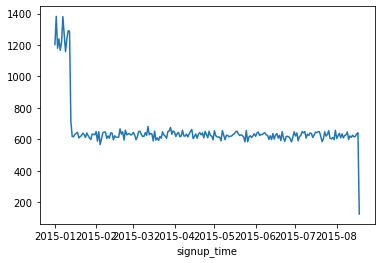

In [17]:
df1.groupby("signup_time").size().plot();

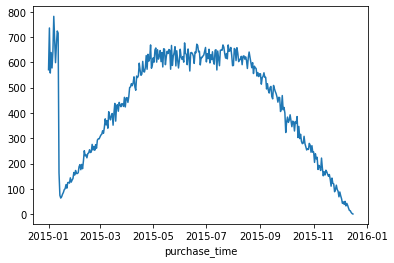

In [18]:
df1.groupby("purchase_time").size().plot();

In [19]:
print(len(df1),df1.user_id.nunique(), df1.signup_time.nunique(),df1.purchase_time.nunique(), df1.device_id.nunique(),df1.source.nunique(),df1.browser.nunique(),df1.country.nunique())

151112 151112 230 350 137956 3 5 182


In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country         151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [21]:
#create a day difference variable between purchase time and signup time
df1['day_delta'] = (df1['purchase_time'] - df1['signup_time'])/np.timedelta64(1,'D')

In [22]:
df1.day_delta.nunique()

121

#### device_id_count and ip_address_count

In [23]:
#There are duplicated values for device_id and ip_address
print(len(df1), df1.device_id.nunique(),df1.ip_address.nunique())

151112 137956 143512


In [24]:
df1.groupby('device_id')['device_id'].transform('count')

0          1
1          1
2         12
3          1
4          1
          ..
151107     2
151108     1
151109     1
151110     2
151111     1
Name: device_id, Length: 151112, dtype: int64

In [25]:
df1['device_id_count'] = df1.groupby('device_id')['device_id'].transform('count')
df1['ip_address_count'] = df1.groupby('ip_address')['ip_address'].transform('count')

In [26]:
df1[df1['device_id_count']!=df1['ip_address_count']].sample(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,day_delta,device_id_count,ip_address_count
74401,133721,2015-02-21,2015-06-10,11,FRNHHKYPEDMKC,SEO,Chrome,M,38,2.38e+09,0,United States,109.0,2,1
36746,371107,2015-06-20,2015-10-05,56,XLMDCSRPXNIAN,SEO,Chrome,M,31,1.27e+09,0,Canada,107.0,2,1
143680,212837,2015-01-23,2015-01-24,16,PCXMDYIERYKNC,Ads,IE,M,33,4.07e+09,0,Not Found,1.0,2,1
45312,53816,2015-06-17,2015-08-28,20,FNJGLBNNEDIEG,SEO,Safari,F,41,1.88e+09,1,China,72.0,2,1
129783,58510,2015-01-26,2015-01-30,41,OIJHSAGIOKCJV,Direct,Chrome,M,32,3.55e+09,1,Japan,4.0,2,1


#### user_id

In [27]:
#Number of records and user id is equal, so all ids are unique, don't need this column
print(len(df1) == df1.user_id.nunique())

True


In [28]:
df1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,day_delta,device_id_count,ip_address_count
0,22058,2015-02-24,2015-04-18,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.33e+08,0,Japan,53.0,1,1
1,333320,2015-06-07,2015-06-08,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.50e+08,0,United States,1.0,1,1
2,1359,2015-01-01,2015-01-01,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62e+09,1,United States,0.0,12,12
3,150084,2015-04-28,2015-05-04,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.84e+09,0,Not Found,6.0,1,1
4,221365,2015-07-21,2015-09-09,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.16e+08,0,United States,50.0,1,1


In [29]:
#create dummies for dept
df_dummy = pd.get_dummies(df1[['day_delta', 'purchase_value','device_id_count', 'source', 'browser',\
                              'sex','age','ip_address_count', 'country','class']], drop_first=True) 

In [34]:
#split train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_dummy.drop(['class'],axis=1), 
                                                    df_dummy['class'], test_size=0.33)

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [41]:
print("Training score: {:.2f}% \n Testing score: {:.2f}%".format(lr.score(X_train, y_train)*100, 
                                                           lr.score(X_test, y_test)*100))

Training score: 95.12% 
 Testing score: 94.95%


In [37]:
#testing set confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, lr.predict(X_test),labels = [0,1]))

,0,1
0,44901,254
1,2266,2446


In [47]:
#double check that with a 0.5 cut-off
probs_y=lr.predict_proba(X_test)[:,1]
pred = lr.predict(X_test)
print(np.array_equal(probs_y.round(), pred))

True


In [45]:
probs_y.shape[:]

(49867, 2)

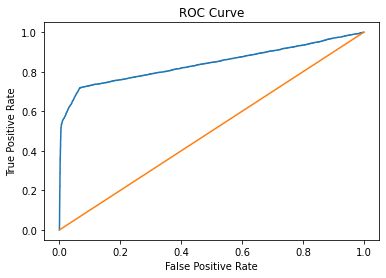

In [50]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, probs_y)
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve');

We want to minimize False Positive Rate(fpr) and maximize True Positive Rate(tpr). According to the ROC curve above, with low FPR, TPR should be slightly below 0.6.

In [74]:
#get TPR range from 0.56 to 0.6
indexes = []
for i,item in enumerate(tpr):
    if item >= 0.56 and item <= 0.6:
        indexes.extend([i])

In [76]:
print("With threshold at {:.2f}, TPR is {:.2f} and FPR is {:.2f}".format(thresholds[indexes[0]],
                                                                         tpr[indexes[0]],fpr[indexes[0]]))
print("With threshold at {:.2f}, TPR is {:.2f} and FPR is {:.2f}".format(thresholds[indexes[-1]],
                                                                         tpr[indexes[-1]],fpr[indexes[-1]]))

With threshold at 0.20, TPR is 0.56 and FPR is 0.01
With threshold at 0.17, TPR is 0.60 and FPR is 0.03


**class 0 error is False Positive Rate**     
**class 1 error is 1 minus True Positive Rate**
                             

In [77]:
opt_df = pd.DataFrame({"Thresholds": pd.Series(thresholds), 
                       "Class0 Error":pd.Series(fpr),"Class1 Error":pd.Series(1- tpr)})

We want to maximize true positive rate - false positive rate which is the same as maximizing (1-class1_error) - class0_error. 

In [79]:
opt_df['optimize'] = 1 - opt_df['Class1 Error'] - opt_df['Class0 Error']
opt_df.sort_values('optimize',ascending = False)[:5]

,Thresholds,Class0 Error,Class1 Error,optimize
2126,0.09,0.07,0.28,0.65
2128,0.08,0.07,0.28,0.65
2124,0.09,0.07,0.28,0.65
2125,0.09,0.07,0.28,0.65
2134,0.08,0.07,0.28,0.65


**Thus, the best optimized point  is TPR at 0.72 and FPR at 0.07**

In [92]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=3, oob_score=True)

In [94]:
#testing results
print("Random Forests' Training score: {:.2f}% \n Testing score: {:.2f}%".format(rf.score(X_train, y_train)*100, 
                                                           rf.score(X_test, y_test)*100))

pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test), labels=[0, 1]))

Random Forests' Training score: 99.98% 
 Testing score: 95.40%


,0,1
0,45059,96
1,2196,2516


#### <a id = "3">Question 3:<a/>

Your boss is a bit worried about using a model she doesn’t understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn’t care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

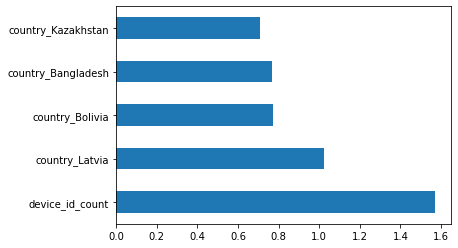

In [88]:
#Logistic Regression
lr_importances = pd.Series(lr.coef_[0], index=X_train.columns)
lr_importances.sort_values(ascending = False).head(5).plot(kind='barh');

By looking at feature importance, device_id_count plays the most influencial role in the model

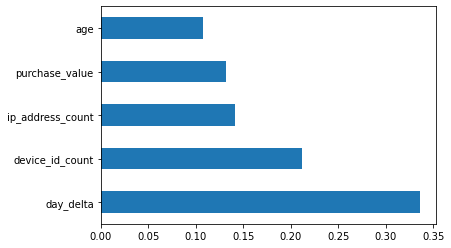

In [96]:
#randorm forests
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
rf_importances.sort_values(ascending = False).head(5).plot(kind='barh');

#### <a id = "4">Question 4:<a/>

Let’s say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output? 

Since there is never a perfect model, I would design some metrics based on different output scores. For example, since fradulent is 1 and 0 otherwiese, if users have moded scores smaller than 0.7, then they would be considered as normal experience, if users have scores between 0.7 and 0.9, they they would be at medium risk, and their transactions would be on hold for further investigation, and if users have scores higher than 0.9, then those are at high risk and manual investigations are needed for this group of users.